In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tropicalOrographicRegions.mountainUtils import *
from tools.generalTools import *; from tools.BLtools import *; from tools.e5tools import *


from scipy.stats import linregress
#xr.set_options(display_style='text') 

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines
from scipy.ndimage import gaussian_filter

plt.rcParams['hatch.color'] = 'w'

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Data

In [2]:
# Monthly data
orogm=xr.open_dataset("../tropicalOrographicRegions/data/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
topo_hires = xr.open_dataarray("../tropicalOrographicRegions/data/ETOPO1_Ice_g_gmt4.nc")
lsm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
imerg_seasmean=xr.open_dataarray("../tropicalOrographicRegions/data/GPM-IMERG-seasonalmean-200101-202012.nc")

In [18]:
%%time
# Create MountainRange objects; add all data
Ghats      = MountainRange("ghats"      ,[64,82,5.5,27] ,"Western Ghats", 70 , [6,7,8]   , [75, 9, 71.5, 20,2]              , path='../tropicalOrographicRegions/data/')
Myanmar    = MountainRange("myanmar"    ,[82,102,5.5,27],"Myanmar"      , 60 , [6,7,8]   , [94.2, 16.5,  91.4  , 21.5 , 1.5], path='../tropicalOrographicRegions/data/')
Vietnam    = MountainRange("vietnam"    ,[100,118,8,25] ,"Vietnam"      , 240, [10,11,12], [108  ,  18  , 111  , 13   ,2], path='/pscratch/sd/q/qnicolas/regionsDataBig/')# path='../tropicalOrographicRegions/data/')
Philippines= MountainRange("philippines",[118,135,5,22] ,"Philippines"  , 225, [11,12]   , [122.5, 19, 127, 9, 2]           , path='../tropicalOrographicRegions/data/')
Malaysia   = MountainRange("malaysia"   ,[95,115,-2,15] ,"Malaysia"     , 225, [11,12]   , [102.5,   8  , 105.5,  3   ,2]   , path='../tropicalOrographicRegions/data/')

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines)

for MR in MRs:
    print(MR.name)
    # Monthly data
    MR.subset_2dvar('IMERG',imerg_seasmean)          #IMERG precip
    MR.subset_2dvar('Z',orogm)                        #ERA5 topography
    MR.subset_2dvar('Z_HR',np.maximum(topo_hires,0.)) #ETOPO1 topography
    
    # Daily data
    MR.set_daily_imerg()
    MR.vars['UBL_DAILY'] = xr.open_dataarray("/pscratch/sd/q/qnicolas/regionsDataBig/" + "e5.oper.an.sfc.228_246_100u.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['VBL_DAILY'] = xr.open_dataarray("/pscratch/sd/q/qnicolas/regionsDataBig/" + "e5.oper.an.sfc.228_247_100v.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    
    #MR.vars['UBL_DAILY'] = xr.open_dataarray(MR.path + "e5.diagnostic.uBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)) # ERA5 u wind averaged surface-900 hPa
    #MR.vars['VBL_DAILY'] = xr.open_dataarray(MR.path + "e5.diagnostic.vBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)) # ERA5 v wind averaged surface-900 hPa
    

ghats
myanmar
vietnam
malaysia
philippines
CPU times: user 6.82 s, sys: 21.3 s, total: 28.1 s
Wall time: 32.1 s


In [19]:
%%time
# Define rain band masks and average stuff in these masks
for MR in (Ghats,Myanmar,Vietnam,Malaysia,Philippines):
    MR.mask_above_era5 = tilted_rect(MR.vars['UBL_DAILY'],*MR.box_tilted,reverse=False)*lsm
    MR.mask_wind_era5 = tilted_rect(MR.vars['UBL_DAILY'],*MR.box_tilted,reverse=True)
    MR.mask_upstream_era5 = tilted_rect_distance(MR.vars['UBL_DAILY'],*MR.box_tilted[:-1],-2,-4)
    MR.mask_above_gpm = tilted_rect(MR.vars['IMERG_DAILY'],*MR.box_tilted,reverse=False)
    MR.mask_upstream_gpm = tilted_rect_distance(MR.vars['IMERG_DAILY'],*MR.box_tilted[:-1],-2,-4)
    
# Average various variables in rain bands or upstream of them
for MR in MRs:
    MR.set_spatialmean('IMERG_DAILY','ABOVE',MR.mask_above_gpm,box=None)
    MR.set_spatialmean('IMERG_DAILY','UPSTREAM',MR.mask_upstream_gpm,box=None)
    MR.set_spatialmean('UBL_DAILY','BOXWIND',MR.mask_wind_era5,box=None)
    MR.set_spatialmean('VBL_DAILY','BOXWIND',MR.mask_wind_era5,box=None)


/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


CPU times: user 3.92 s, sys: 8.43 s, total: 12.4 s
Wall time: 13.2 s


In [20]:
%%time
# Define rain band masks and average stuff in these masks
for MR in (Ghats,Myanmar,Vietnam,Malaysia,Philippines):
    MR.mask_farupstream_gpm = tilted_rect_distance(MR.vars['IMERG_DAILY'],*MR.box_tilted[:-1],-4,-6)
    MR.set_spatialmean('IMERG_DAILY','FARUPSTREAM',MR.mask_farupstream_gpm,box=None)
    

/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/common/software/m3310/conda/xrdask.2024.03.qn/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


CPU times: user 1.24 s, sys: 2.75 s, total: 3.99 s
Wall time: 4.08 s


In [7]:
# Plotting functions
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='', labelpos='E', coordinates='axes',color='k',angle=90)
    return q

def add_latlon(ax,box,ftz=None):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    
    ax.set_xticks(lons, crs=ccrs.PlateCarree())
    ax.set_yticks(lats, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if ftz:
        ax.tick_params(axis='both', which='major', labelsize=ftz)
    
    ax.set_xlabel("")
    ax.set_ylabel("")

In [8]:
def plot_regs(MR,precip_mag=30,farupstream = False):
    ### DATA
    wind_ts = crossslopeflow(MR.vars['UBL_DAILY_BOXWIND'],MR.vars['VBL_DAILY_BOXWIND'],MR.angle)
    precip = MR.vars['IMERG_DAILY'].transpose('time','latitude','longitude')
    
    fig,axs=plt.subplots(1,2,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
    ### FIRST PLOT ###
    precip.mean('time').plot.contourf(ax=axs[0],
                                                      transform=ccrs.PlateCarree(),
                                                      levels=np.linspace(0,precip_mag,11),
                                                      cmap=plt.cm.GnBu)
    
    ### SECOND PLOT ###
    precip_reg = linregress_xr(wind_ts,precip,dim='time')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1) * precip_reg.pvalue**0
    (100*precip_reg.slope/precip.mean('time')).plot.contourf(ax=axs[1],
                                                             transform=ccrs.PlateCarree(),
                                                             levels=np.linspace(-30,30,13),
                                                             extend='both',
                                                             cbar_kwargs={'shrink':0.8,'label':r"%$\,\left(\text{m}\,\text{s}^{-1}\right)^{-1}$"})
    
    hatches = fdrfact.plot.contourf(ax=axs[1], levels=[0.5,1], colors='none', hatches=['','//'], alpha=0,add_colorbar=False) 
    
    precip_ts = MR.vars['IMERG_DAILY_ABOVE']
    slope0 = linregress_xr(wind_ts,precip_ts,dim='time').slope
    sensitivity0 = 100* slope0 / precip_ts.mean('time')
    
    joint_sample = generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data)),blocksize=1)
    wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','time'])
    precip_sample = xr.DataArray(joint_sample[1],dims = ['bootstrap','time'])
    slope_sample = linregress_xr(wind_sample,precip_sample,dim='time').slope
    sensitivity_sample = 100* slope_sample / precip_sample.mean('time')
    print("P  sensitivity: %.1f [%.1f - %.1f] %% / (m/s)"%(sensitivity0, np.quantile(sensitivity_sample,0.025),np.quantile(sensitivity_sample,0.975)))
    
    if farupstream:
        precip_ts_upstream = MR.vars['IMERG_DAILY_FARUPSTREAM']
    else:
        precip_ts_upstream = MR.vars['IMERG_DAILY_UPSTREAM']
    slope0 = linregress_xr(wind_ts,precip_ts-precip_ts_upstream,dim='time').slope
    sensitivity0 = 100* slope0 / (precip_ts-precip_ts_upstream).mean('time')
    
    joint_sample = generate_joint_sample(np.vstack((wind_ts.data, precip_ts.data,precip_ts_upstream.data)),blocksize=1)
    wind_sample = xr.DataArray(joint_sample[0],dims = ['bootstrap','time'])
    pprime_sample = xr.DataArray(joint_sample[1]-joint_sample[2],dims = ['bootstrap','time'])
    slope_sample = linregress_xr(wind_sample,pprime_sample,dim='time').slope
    sensitivity_sample = 100* slope_sample / pprime_sample.mean('time')
    
    print("P' sensitivity: %.1f [%.1f - %.1f] %% / (m/s) calculating P0 200-400km upstream"%(sensitivity0, np.quantile(sensitivity_sample,0.025),np.quantile(sensitivity_sample,0.975)))

    ### DECORATION ###
    MR.mask_wind_era5.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),levels=[0.5],colors='b',linestyles=['--']) 
    for ax in axs:
        MR.vars['Z_HR'].plot.contour(ax=ax,levels=[500.],colors='#555555',linewidths=[1.])
        MR.mask_above_era5.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[0.5],colors='k',linestyles=['--']) 
        ax.coastlines(linewidth=2)
        add_latlon(ax,MR.box)
    axs[0].set_title('Mean precip')
    axs[1].set_title('Precip sensitivity to wind in box with FDR mask')

# With u100,v100

P  sensitivity: 14.7 [13.2 - 16.2] % / (m/s)
P' sensitivity: 28.9 [26.1 - 32.0] % / (m/s) calculating P0 200-400km upstream


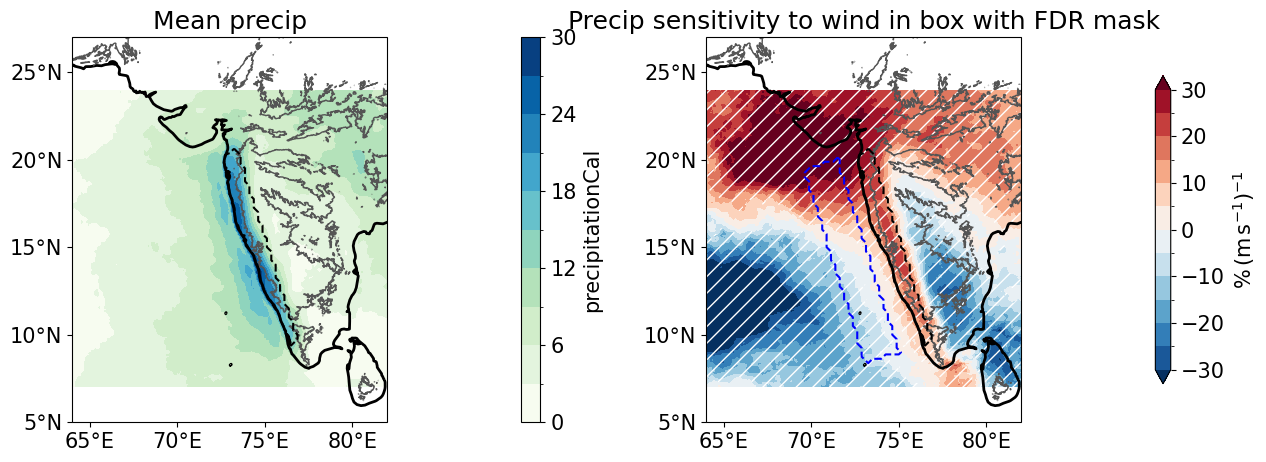

In [9]:
plot_regs(Ghats)

P  sensitivity: 21.6 [20.2 - 23.0] % / (m/s)
P' sensitivity: 33.2 [27.8 - 39.5] % / (m/s) calculating P0 200-400km upstream


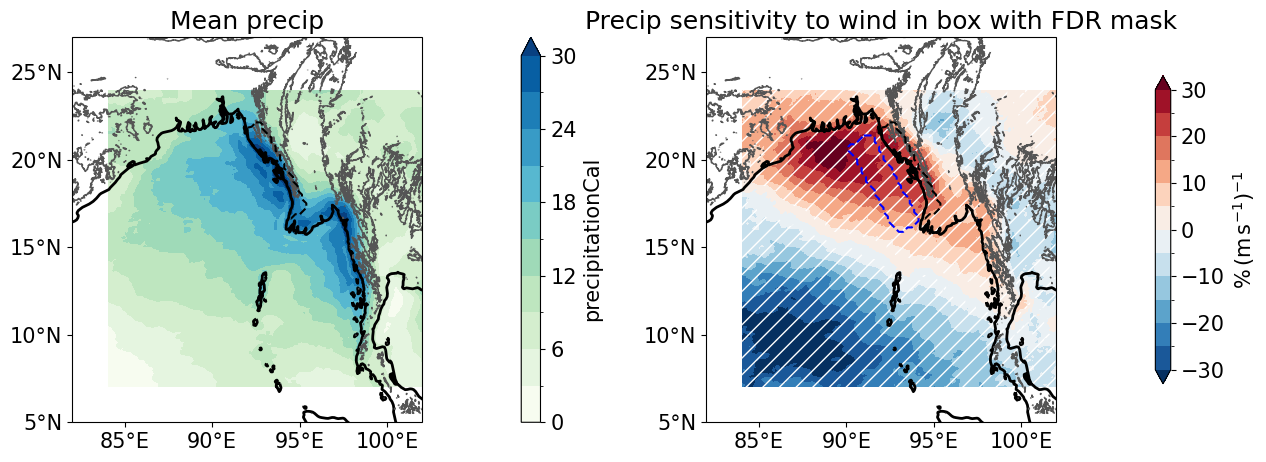

In [10]:
plot_regs(Myanmar)

P  sensitivity: 8.1 [4.8 - 11.4] % / (m/s)
P' sensitivity: 30.5 [21.3 - 43.3] % / (m/s) calculating P0 200-400km upstream


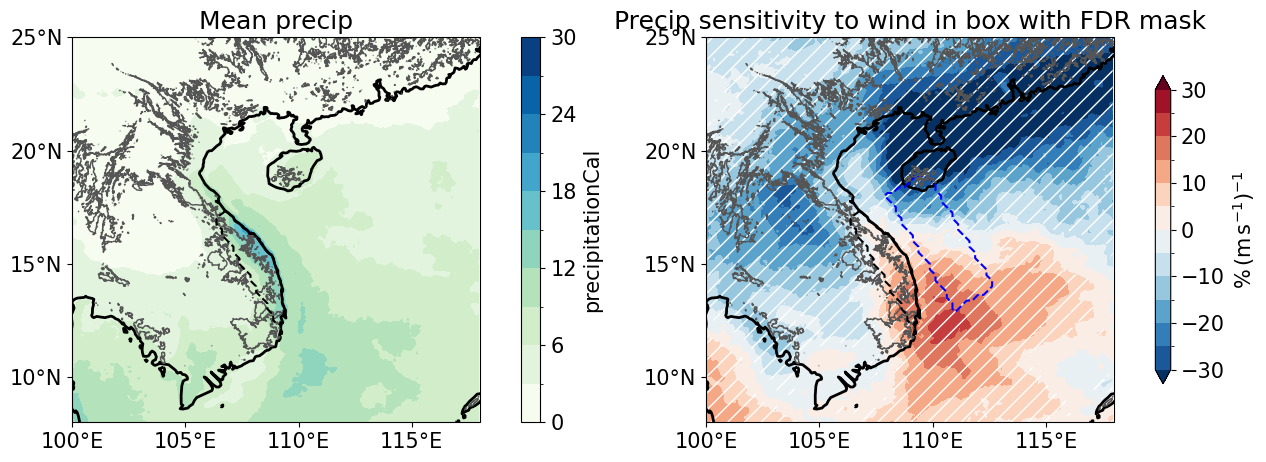

In [11]:
plot_regs(Vietnam)

P  sensitivity: 5.2 [2.0 - 8.2] % / (m/s)
P' sensitivity: 26.5 [17.9 - 38.3] % / (m/s) calculating P0 200-400km upstream


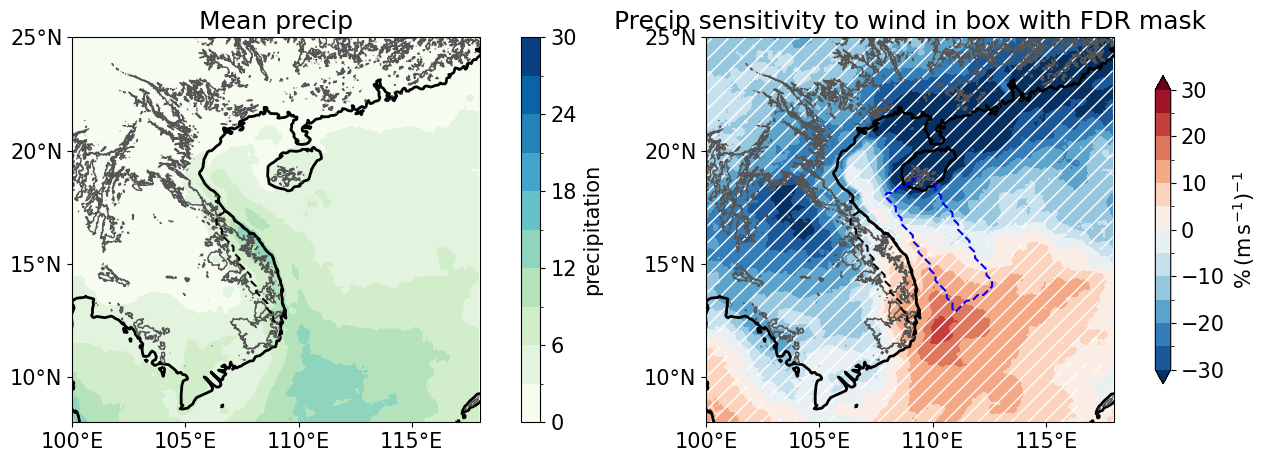

In [21]:
plot_regs(Vietnam) # with december

P  sensitivity: 5.0 [2.3 - 7.7] % / (m/s)
P' sensitivity: 10.6 [4.2 - 17.4] % / (m/s) calculating P0 200-400km upstream


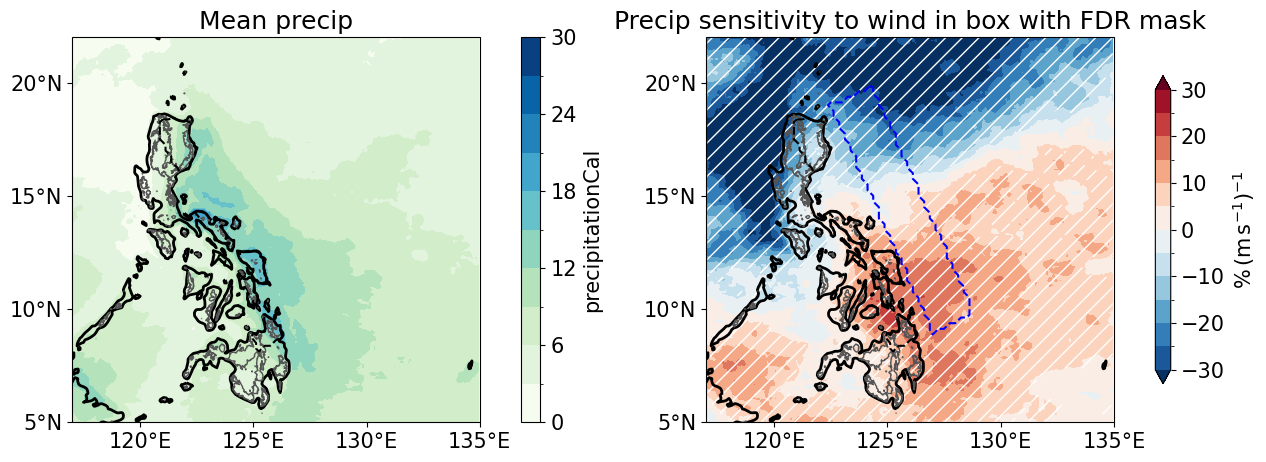

In [12]:
plot_regs(Philippines)

P  sensitivity: 11.5 [9.6 - 13.5] % / (m/s)
P' sensitivity: 17.7 [14.5 - 21.0] % / (m/s) calculating P0 200-400km upstream


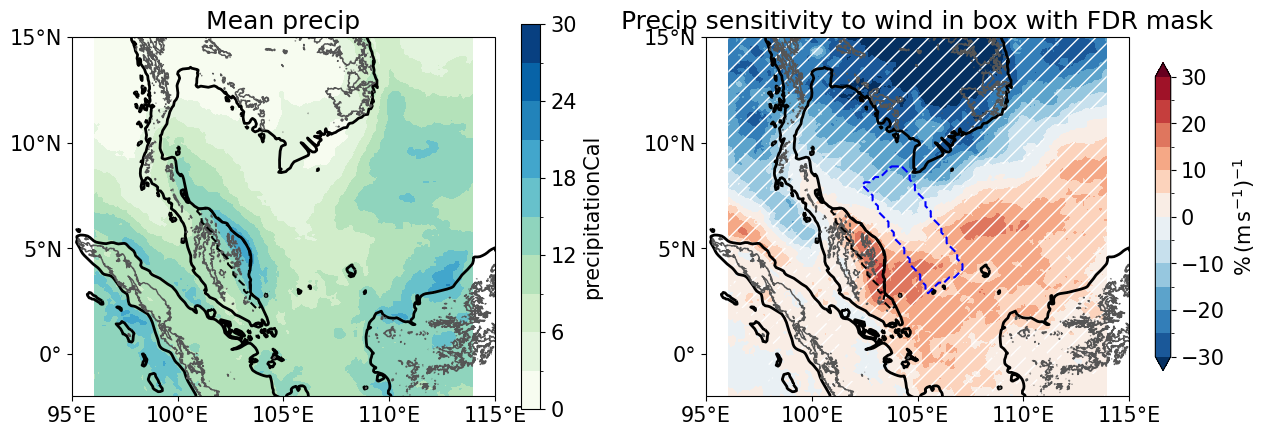

In [13]:
plot_regs(Malaysia)

# With UBL,VBL

P  sensitivity: 11.5 [10.4 - 12.6] % / (m/s)
P' sensitivity: 22.4 [20.2 - 24.7] % / (m/s) calculating P0 200-400km upstream


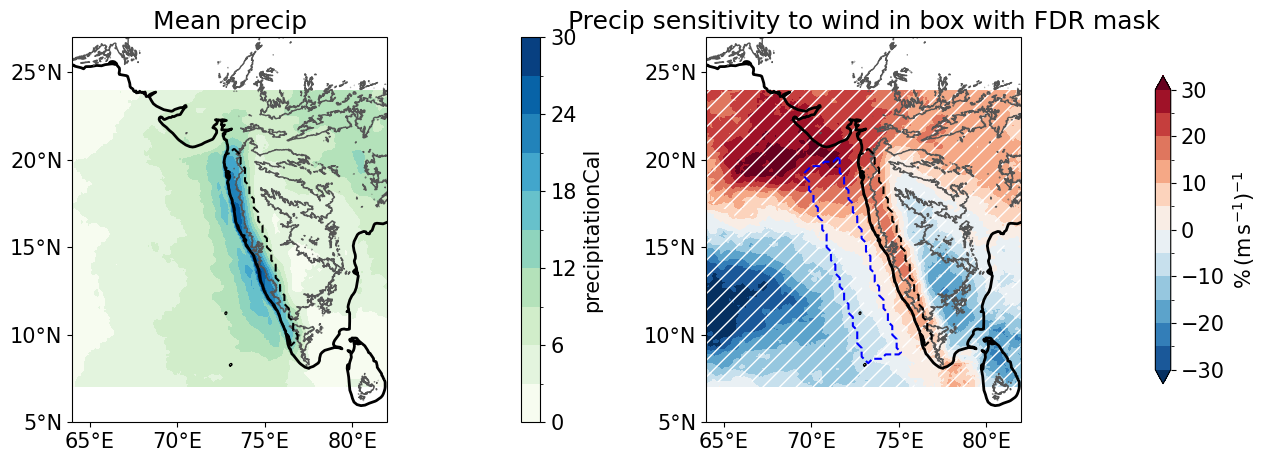

In [26]:
plot_regs(Ghats)

P  sensitivity: 17.8 [16.7 - 18.9] % / (m/s)
P' sensitivity: 30.0 [25.4 - 35.7] % / (m/s) calculating P0 200-400km upstream


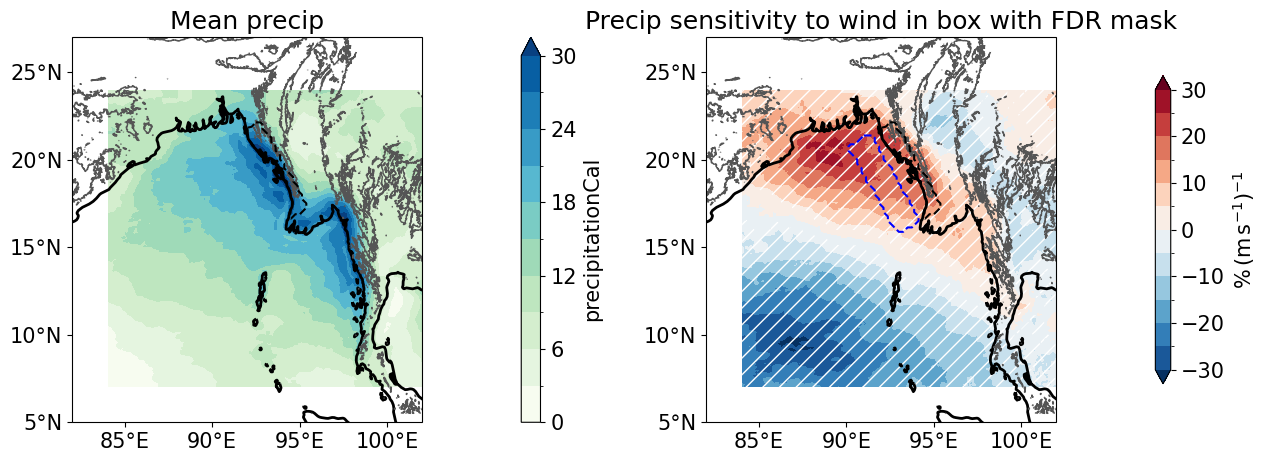

In [27]:
plot_regs(Myanmar)

P  sensitivity: 8.4 [5.4 - 11.4] % / (m/s)
P' sensitivity: 26.2 [18.6 - 37.1] % / (m/s) calculating P0 200-400km upstream


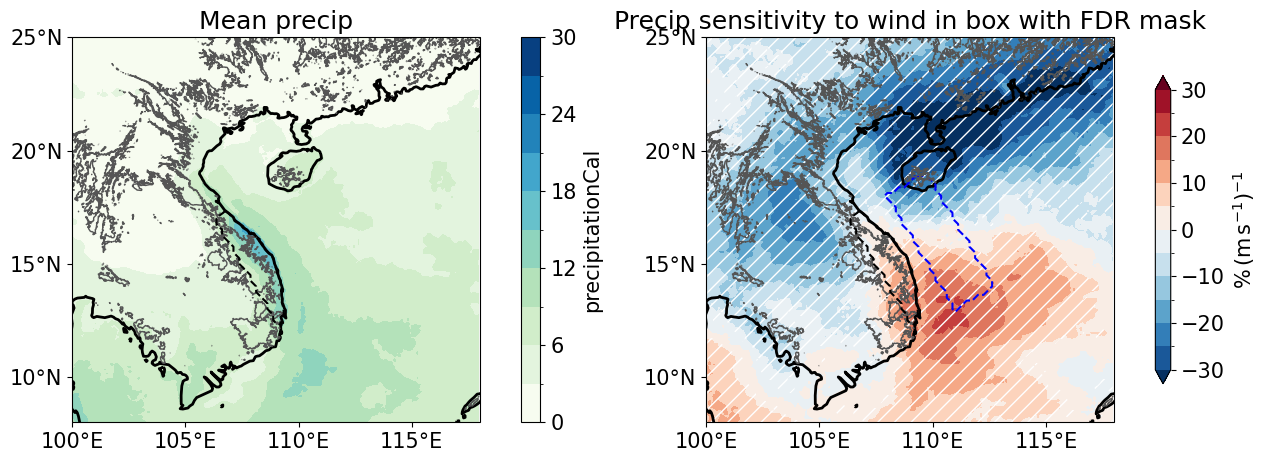

In [28]:
plot_regs(Vietnam)

P  sensitivity: 4.8 [2.2 - 7.4] % / (m/s)
P' sensitivity: 8.1 [1.9 - 14.4] % / (m/s) calculating P0 200-400km upstream


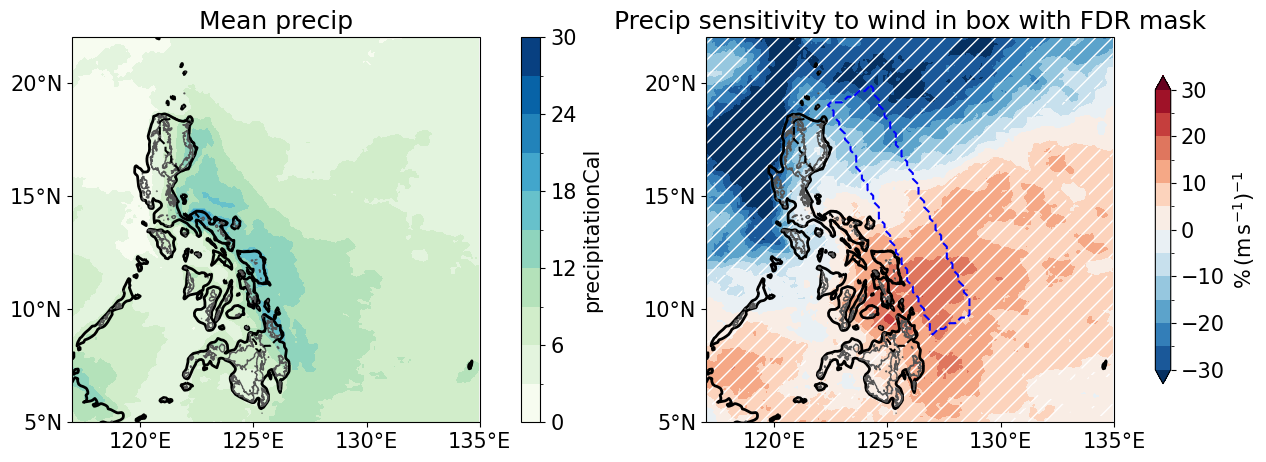

In [29]:
plot_regs(Philippines)

P  sensitivity: 10.5 [8.8 - 12.2] % / (m/s)
P' sensitivity: 15.2 [12.5 - 17.9] % / (m/s) calculating P0 200-400km upstream


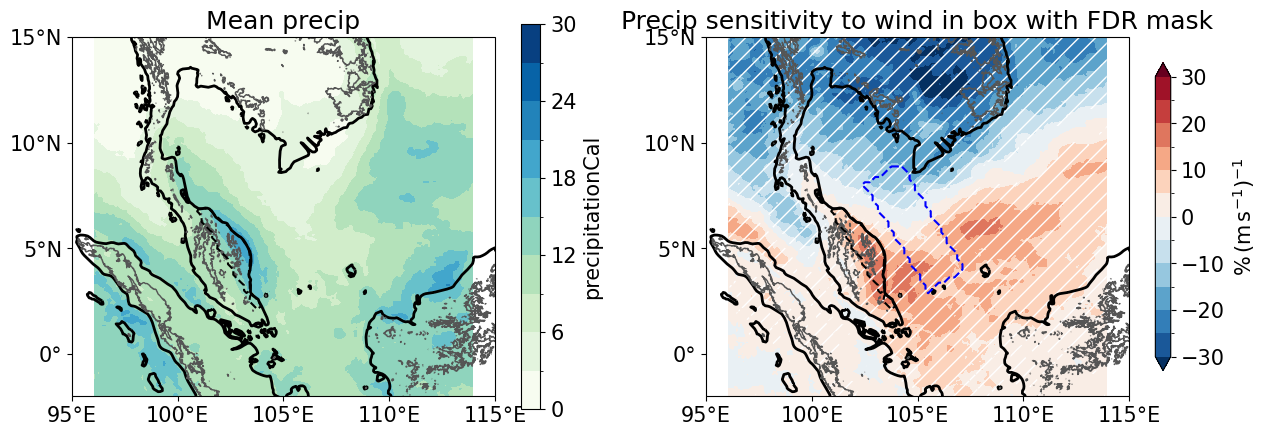

In [30]:
plot_regs(Malaysia)